In [2]:
### Check if GPU is available ###
!nvidia-smi

Tue Mar  9 14:04:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 26%   32C    P8     5W / 300W |     31MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [35]:
import os
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt

### PyTorch dependencies ###
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

### Some constants ###
H, W, C = 256, 256, 3
LATENT_DIM = 128

# Loading and processing data for training

In [36]:
data_dir = "/home/minhhieu/Desktop/Hieu/datasets/img_align_celeba"
data_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])
image_dataset = datasets.ImageFolder(data_dir, transform=data_transform)
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=64, shuffle=True)

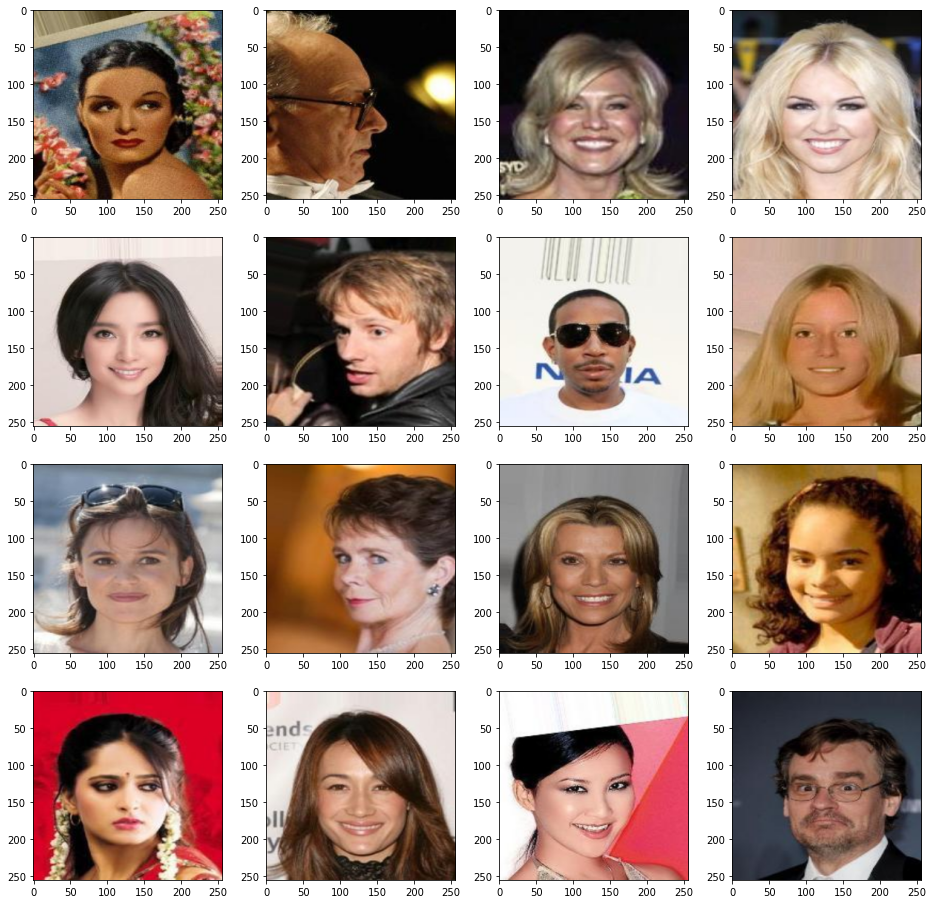

In [37]:
### Scaling image to [-1, 1] range ###
def scale(img, feature_range=(-1, 1)):    
    # Assuming img is scaled in [0, 1] range
    # scale x by feature range
    x = img * (feature_range[1] - feature_range[0]) + feature_range[0]
    return x

### Show sample image data ###
data_iter = iter(dataloader)
images, _ = data_iter.next()

# Detach the tensors to numpy array and reshape to opencv format
images = images.detach().numpy()
# images = images.reshape(-1, H, W, C)

grid_size = 4
fig, ax = plt.subplots(grid_size,grid_size, figsize=(16, 16))

for i in range(grid_size**2):
    row = i // grid_size
    col = i %  grid_size
    
    image = np.transpose(images[i], (1, 2, 0))
    ax[row][col].imshow(image)
plt.show()

# Create the models

In [65]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1) # Size / 2 = 128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # Size / 4 = 64
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # Size / 8 = 32
        self.norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) # Size /8 = 32
        self.norm4 = nn.BatchNorm2d(256)
        self.fc    = nn.Linear(256*32*32, 1)
        
    def forward(self, inputs):
        out = F.leaky_relu(self.conv1(inputs), 0.2)
        out = F.leaky_relu(self.norm2(self.conv2(out)), 0.2)
        out = F.leaky_relu(self.norm3(self.conv3(out)), 0.2)
        out = F.leaky_relu(self.norm4(self.conv4(out)), 0.2)
        
        # flatten
        out = out.view(-1, 256*32*32)
        out = self.fc(out)
        
        return out
    
D = Discriminator()

In [66]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc     = nn.Linear(LATENT_DIM, 256*32*32)
        self.tconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1  = nn.BatchNorm2d(128)
        self.tconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm2  = nn.BatchNorm2d(64)
        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm3  = nn.BatchNorm2d(32)
        self.tconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False)
        
    def forward(self, inputs):
        out = self.fc(inputs)
        out = out.view(-1, 256, 32, 32)
        out = F.relu(self.norm1(self.tconv1(out)))
        out = F.relu(self.norm2(self.tconv2(out)))
        out = F.relu(self.norm3(self.tconv3(out)))
        out = self.tconv4(out)
        out = torch.tanh(out)
        
        return out
    
G = Generator()

# Initialize parameters of the network

In [67]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
      init.normal_(m.weight.data, 0.0, 0.02)
      if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)

D.apply(weights_init_normal)
G.apply(weights_init_normal)

Generator(
  (fc): Linear(in_features=128, out_features=262144, bias=True)
  (tconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

# Start training

In [70]:
# params
lr         = 0.0002
beta1      = 0.5
beta2      = 0.999
epochs     = 1000
batch_size = 64
train_gpu  = False

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# Create criterions for the discriminator D and generator G
bce   = nn.BCEWithLogitsLoss()
zeros = torch.zeros(batch_size, 1)
ones  = torch.ones(batch_size, 1) * 0.9 # smooth labels

def generate_img(image_list):
    grid_size = 4
    final_img = None
    hor_imgs = []
    
    image_list = (image_list + 1.0) / 2.0
    image_list = image_list.cpu().detach().numpy()
    for i in range(0, len(image_list), grid_size):
        img1 = np.transpose(image_list[i], (1, 2, 0))
        img2 = np.transpose(image_list[i+1], (1, 2, 0))
        img3 = np.transpose(image_list[i+2], (1, 2, 0))
        img4 = np.transpose(image_list[i+3], (1, 2, 0))

        hor_img = cv2.hconcat([img1, img2, img3, img4])
        hor_imgs.append(hor_img)
            
    final_img = cv2.vconcat([hor_imgs[0], hor_imgs[1], hor_imgs[2], hor_imgs[3]])
    return final_img

def generate_gif(image_list):
    with imageio.get_writer('images/output.gif', mode='I') as writer:
        for image in image_list:
            image = imageio.core.util.Array(image)
            writer.append_data(image)
    
if(torch.cuda.is_available()):
    print('[INFO] Training with GPU ... ')
    train_gpu = True
    G.cuda()
    D.cuda()
    zeros = zeros.cuda()
    ones = ones.cuda()
    
sample_z = np.random.uniform(-1, 1, size=(16, LATENT_DIM))
sample_z = torch.from_numpy(sample_z).float()
if(train_gpu) : sample_z = sample_z.cuda()
sample_outputs = []

for epoch in range(epochs):
    d_losses = []
    g_losses = []
    for batch_id, (real_images, _) in enumerate(dataloader):
        ### Train discriminator phase ###
        d_optimizer.zero_grad()
        D.train() # turn discriminator to training mode
        G.eval() # turn generator to evaluation mode
        
        real_images = scale(real_images)
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, LATENT_DIM))
        z = torch.from_numpy(z).float()
        
        if(train_gpu):
            real_images = real_images.cuda()
            z = z.cuda()
            
        fake_images = G(z)
        D_fake = D(fake_images)
        D_real = D(real_images)
        
        d_fake_loss = bce(D_fake, zeros)
        d_real_loss = bce(D_real, ones)
        d_loss = d_fake_loss + d_real_loss 
        d_loss.backward()
        d_optimizer.step()
        
        ### Train generator phase ###
        g_optimizer.zero_grad()
        D.eval() # turn discriminator to evaluation mode
        G.train() # turn generator to training mode
        
        z = np.random.uniform(-1, 1, size=(batch_size, LATENT_DIM))
        z = torch.from_numpy(z).float()
        
        if(train_gpu):
            z = z.cuda()
        
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = bce(D_fake, ones)
        g_loss.backward()
        g_optimizer.step()
        
        d_losses.append(d_loss.cpu().detach().numpy())
        g_losses.append(g_loss.cpu().detach().numpy())
        
        print('    BATCH #%d, D loss = %.5f, G loss = %.5f' % (batch_id, d_loss, g_loss))
        
        if((batch_id + 1) % 100 == 0):
            sample_output = generate_img(G(sample_z))
            sample_outputs.append(sample_output)
            generate_gif(sample_outputs)
            os.system('clear')
        
    mean_d_loss = np.array(d_losses).mean()
    mean_g_loss = np.array(g_losses).mean()
    print('EPOCH #[%d/%d], D loss = %.5f, G loss = %.5f' % (epoch, epochs, mean_d_loss, mean_g_loss))
        

[INFO] Training with GPU ... 
    BATCH #0, D loss = 0.69509, G loss = 0.38668
    BATCH #1, D loss = 2.03403, G loss = 0.75374
    BATCH #2, D loss = 1.68050, G loss = 0.68436
    BATCH #3, D loss = 1.52023, G loss = 0.45126
    BATCH #4, D loss = 1.20361, G loss = 0.43980
    BATCH #5, D loss = 1.07672, G loss = 0.35749
    BATCH #6, D loss = 0.97848, G loss = 0.50454
    BATCH #7, D loss = 0.87010, G loss = 0.36679
    BATCH #8, D loss = 1.32034, G loss = 0.36636
    BATCH #9, D loss = 1.28415, G loss = 0.39269
    BATCH #10, D loss = 1.44456, G loss = 0.41981
    BATCH #11, D loss = 1.17859, G loss = 0.38688
    BATCH #12, D loss = 1.65655, G loss = 0.34878
    BATCH #13, D loss = 1.48331, G loss = 0.39488
    BATCH #14, D loss = 0.81628, G loss = 0.38939
    BATCH #15, D loss = 1.29262, G loss = 0.39157
    BATCH #16, D loss = 0.96630, G loss = 0.38749
    BATCH #17, D loss = 1.04601, G loss = 0.34533
    BATCH #18, D loss = 1.41995, G loss = 0.34384
    BATCH #19, D loss = 1.1125

KeyboardInterrupt: 

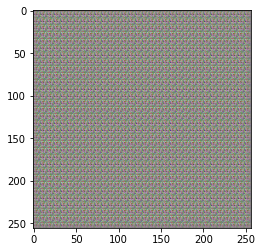

In [71]:
samples = (G(sample_z) + 1)/2
samples = samples.cpu().detach().numpy()
samples = np.transpose(samples, (0,2,3,1))

plt.imshow(samples[1])
plt.show()

In [78]:
print(D(G(sample_z)))
data_iter = iter(dataloader)
images, _ = data_iter.next()
images = scale(images).cuda()
print(D(images))

tensor([[-28.2745],
        [-32.2434],
        [-35.2714],
        [-26.2001],
        [-26.3320],
        [-25.8692],
        [-32.8491],
        [-26.3013],
        [-28.7826],
        [-32.9326],
        [-28.9044],
        [-24.3154],
        [-30.6667],
        [-30.3355],
        [-24.1143],
        [-22.3175]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 3.9044e-01],
        [ 3.5495e+00],
        [ 2.8270e+00],
        [-1.7742e-02],
        [ 3.9649e+00],
        [ 2.1405e+00],
        [ 4.6685e+00],
        [ 4.0596e+00],
        [ 3.2413e+00],
        [ 4.3548e+00],
        [-5.7860e-01],
        [ 8.4577e-01],
        [ 5.8693e+00],
        [ 3.0830e+00],
        [ 6.6345e-01],
        [-1.1173e+00],
        [ 5.3421e+00],
        [ 3.8488e+00],
        [ 2.0003e-01],
        [ 4.7591e+00],
        [ 8.8647e-01],
        [ 1.4502e+01],
        [ 3.7220e+00],
        [ 2.4180e+00],
        [-3.4203e+00],
        [ 5.9854e+00],
        [-1.6209e-01],
        [ 4.9083